In [1]:
import os

# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import argparse
import copy
from glob import glob
from tqdm import tqdm

import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# # segment anything
# from segment_anything import build_sam, SamPredictor
# from segment_anything_hq import sam_model_registry_baseline
# from segment_anything_hq import SamPredictor as SamPredictorHQ

# segment anything HQ
# import sys
# sys.path.append(os.path.abspath(os.path.dirname(__file__)))
# segment anything
from segment_anything import (
    sam_model_registry,
    sam_hq_model_registry,
    SamPredictor
)
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

In [3]:
class BLIP2():
    def __init__(self, device='cuda'):
        self.device = device
        from transformers import AutoProcessor, Blip2ForConditionalGeneration
        self.processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
        self.model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16).to(device)

    @torch.no_grad()
    def __call__(self, image):
        image = Image.fromarray(image)
        inputs = self.processor(image, return_tensors="pt").to(self.device, torch.float16)

        generated_ids = self.model.generate(**inputs, max_new_tokens=20)
        generated_text = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

        return generated_text

In [4]:
### Grounded SAM
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model 

In [5]:
def grounded_sam(text_prompt, local_image_path, groundingdino_model, sam_predictor):
    # Use this command for evaluate the Grounding DINO model
    # Or you can download the model by yourself
    # ckpt_repo_id = "ShilongLiu/GroundingDINO"
    # ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
    # ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

    # groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

    # sam_checkpoint = 'pretrained_sam/sam_vit_h_4b8939.pth'
    # sam = build_sam(checkpoint=sam_checkpoint)
    # device = "cpu"
    # sam.to(device=device)
    # sam_predictor = SamPredictor(sam)

    import io

    # TEXT_PROMPT = f"The largest {class_name}"
    # TEXT_PROMPT = f"{opt.text} {class_name}"
    TEXT_PROMPT = text_prompt
    BOX_TRESHOLD = 0.3
    TEXT_TRESHOLD = 0.25

    image_source, image = load_image(local_image_path)

    boxes, logits, phrases = predict(
        model=groundingdino_model, 
        image=image, 
        caption=TEXT_PROMPT, 
        box_threshold=BOX_TRESHOLD, 
        text_threshold=TEXT_TRESHOLD
    )

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB

    # Image.fromarray(image_source)
    # Image.fromarray(annotated_frame)

    # set image
    sam_predictor.set_image(image_source)

    # box: normalized box xywh -> unnormalized xyxy
    H, W, _ = image_source.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

    transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)

    masks, _, _ = sam_predictor.predict_torch(
                point_coords = None,
                point_labels = None,
                boxes = transformed_boxes,
                multimask_output = False,
            )

    def show_mask(mask, image, random_color=True):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        
        annotated_frame_pil = Image.fromarray(image).convert("RGBA")
        mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

        return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

    def get_mask(mask):
        h, w = mask.shape[-2:]
        mask = mask.type(torch.float64)
        mask = (mask.cpu().numpy() * 255).astype(np.uint8)
        
        # mask_image_pil = Image.fromarray((mask.cpu().numpy() * 255).astype(np.uint8))
        # mask_image_pil = mask_image_pil.convert("RGBA")

        # foreground: white (255), background: black (0)
        # return mask_image_pil
        # return np.array(mask_image_pil)
        return mask
 
    return masks[0][0].cpu().numpy()
    return get_mask(masks[0][0])
    
    annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)
    
    # RGBA -> RGB
    pil_img = Image.fromarray(annotated_frame_with_mask[..., :3])
    pil_img.save("_dino4.jpg")

    image_mask = masks[0][0].cpu().numpy()

    image_source_pil = Image.fromarray(image_source)
    annotated_frame_pil = Image.fromarray(annotated_frame)
    image_mask_pil = Image.fromarray(image_mask)
    annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)

    # image_mask_pil

In [7]:
from typing import Any, List, Tuple, Union

class EasyDict(dict):
    """Convenience class that behaves like a dict but allows access with the attribute syntax."""

    def __getattr__(self, name: str) -> Any:
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)

    def __setattr__(self, name: str, value: Any) -> None:
        self[name] = value

    def __delattr__(self, name: str) -> None:
        del self[name]

In [9]:
opt = EasyDict()
opt.root = "/node_data/ugkim/sitto/src/pix3d/desk/image/pix3d_desk_0318_img.jpg"
opt.single_image = True
opt.single_dir = False
opt.text = "The largest"
opt.size = 256
opt.border_ratio = 0.2
opt.recenter = True
opt.dont_recenter = False

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

# Grounding DINO
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

# SAM
# sam_checkpoint = '../pretrained_sam/sam_vit_h_4b8939.pth'
# sam = build_sam(checkpoint=sam_checkpoint)
# device = "cpu"
# sam.to(device=device)
# sam_predictor = SamPredictor(sam)

# SAM-HQ
sam_hq_chekpoint = './pretrained_sam/sam_hq_vit_h.pth'
device = "cpu"
sam_predictor = SamPredictor(sam_hq_model_registry["vit_h"](checkpoint=sam_hq_chekpoint).to(device))

# BLIP
blip2 = BLIP2()


final text_encoder_type: bert-base-uncased
Model loaded from /home/ugkim/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
<All keys matched successfully>


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:

# segment_image(opt, class_name, groundingdino_model, sam_predictor)

# opt.path = opt.root

# opt.path = "/node_data/ugkim/sitto/src/pix3d/desk/image/pix3d_desk_0318_img.jpg"
opt.path = "/node_data/ugkim/sitto/src/pix3d_im3d/chair/image/pix3d_chair_0169_img.jpg"

class_name = os.path.dirname(opt.path).split("/")[-2]

out_dir = os.path.dirname(opt.path)
out_rgba = os.path.join(out_dir, os.path.basename(opt.path).split('.')[0] + '_rgba.png')
out_caption = os.path.join(out_dir, os.path.basename(opt.path).split('.')[0] + '_caption.txt')

# load image
print(f'[INFO] loading image...')
image = cv2.imread(opt.path, cv2.IMREAD_UNCHANGED)
if image.shape[-1] == 4:
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# carve background
# print(f'[INFO] background removal...')

# TODO: change text prompt
# opt.path = "/node_data/ugkim/sitto/src/pix3d/desk/image/pix3d_desk_0318_img.jpg"
# opt.path = "/node_data/ugkim/sitto/src/pix3d_im3d/chair/image/pix3d_chair_0169_img.jpg"

opt.text = "The largest"
# opt.text = "The most front-facing middle"


[INFO] loading image...
[INFO] background removal...


In [16]:
print(f'[INFO] captioning...')
caption = blip2(image)
caption

[INFO] captioning...


'a black office chair with arms and wheels'

[INFO] segmentation...


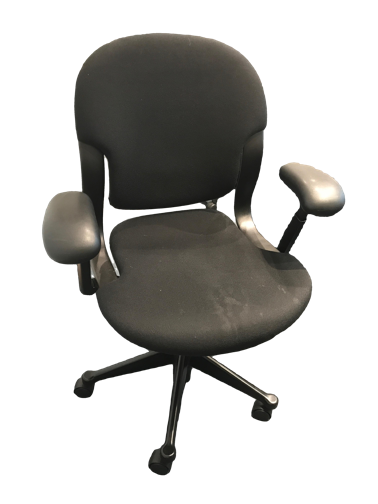

In [19]:
print("[INFO] segmentation...")
text_prompt = f"{opt.text} {class_name}"
mask = grounded_sam(text_prompt, opt.path, groundingdino_model, sam_predictor) # [H, W]
masked_image = (image * mask[..., None] + (255 - mask * 255)[..., None]).astype(np.uint8)
alpha = ((mask * 255)[..., None]).astype(np.uint8)
carved_image = np.concatenate((masked_image, alpha), axis=-1)
pil_image = Image.fromarray(carved_image)
H, W = pil_image.size
pil_image.resize((H // 8, W // 8))

[INFO] segmentation...


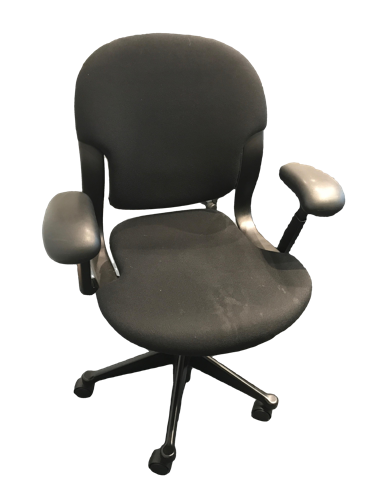

In [20]:
print("[INFO] segmentation...")
text_prompt = caption
mask = grounded_sam(text_prompt, opt.path, groundingdino_model, sam_predictor) # [H, W]
masked_image = (image * mask[..., None] + (255 - mask * 255)[..., None]).astype(np.uint8)
alpha = ((mask * 255)[..., None]).astype(np.uint8)
carved_image = np.concatenate((masked_image, alpha), axis=-1)
pil_image = Image.fromarray(carved_image)
H, W = pil_image.size
pil_image.resize((H // 8, W // 8))